# **The Analysis of Oil Futures with Respect to Macroeconomic Factors**
**Spring 2025 Data Science Project - CMSC 320**

**Collaborators**: Eric Chen, Arjun Mudda, Alexander Rauch

**Contributions:**
* **Eric Chen:** A, B, D, E. Worked on training/designing the elastic net model and its visualization, correlation matrix visualization, and scraped/cleaned the data.
* **Arjun Mudda:** B, C, F, G . Explored and analyzed the correlation data for all of the macroeconomic factors vs Oil.
* **Alexander Rauch:** C, F, G, E. Visualized the data for Oil vs US Bonds, Oil vs Alternative Oil, and Oil vs US Dollar. Performed the validation and R2 tests on the elastic net model.

---

## **Introduction**
It is well known that crude oil is one of the most important global commodities, influencing everything from transportation costs and industrial production to inflation rates and even has implications for geopolitical stability. The price of oil, based on benchmarks like West Texas Intermediate (WTI), is notoriously volatile, since it is affected by a complex mix of factors such as supply, demand, economic health, and ever changing investor sentiment. Understanding these factors that drive oil prices is crucial for policymakers, businesses, investors, and consumers alike.

This project aims to explore the relationship between these WTI crude oil prices and a set of key macroeconomic factors. Specifically, we seek to answer the following questions:
1. Which macroeconomic factors exhibit the strongest correlation (be it positive or negative) with WTI crude oil prices?
2. Can we build a predictive model using these macroeconomic factors to successfully forecast oil price movements with a reasonable amount of accuracy?
3. What insights can we get from these relationships about the broader economic landscape?

Answering these questions is important because accurate oil price forecasting can aid in many fields such as economic planning, risk management for businesses, and investment strategies. Furthermore, identifying the strongest correlations can increase our understanding of how the many different factors of the economy are interconnected. This tutorial will walk through the data science pipeline, from acquiring and cleaning relevant financial data to performing exploratory analysis, building a machine learning model, and interpreting the results.

---

## **Data Collection**
We were able to find around 30 years worth of data on investing.com for Oil, Bond, Dollar, Euro, Exxon, Gold, Yen, Ng, Spy.

The links for these datasets are below, respectively...

* Oil: https://www.investing.com/commodities/crude-oil
* Bond: https://www.investing.com/rates-bonds/u.s.-10-year-bond-yield
* Dollar: https://www.investing.com/indices/usdollar?cid=1224074
* Euro: https://www.investing.com/currencies/eur-usd
* Gold: https://www.investing.com/commodities/gold
* Yen: https://www.investing.com/currencies/usd-jpy
* Natural Gas: https://www.investing.com/commodities/natural-gas
* Spy: https://www.investing.com/indices/usdollar?cid=1224074


The analysis utilizes daily price data for WTI Crude Oil, as well as eight key macroeconomic factors spanning several years (basically from 19991 to present). The datasets used are:

1. Crude Oil (WTI): Our target variable (oil_data.csv)
2. US 10-Year Treasury Bonds: Represents interest rates/safe-haven demand (bond.csv)
3. US Dollar Index (DXY): Represents the strength of the US dollar (dollar_data.csv)
4. Euro (EUR/USD): Represents the strength of a major competing currency (eur_data.csv)
5. Exxon Mobil Stock (XOM): Proxy for shale/alternative oil production and major oil company performance (exxon.csv)
6. Gold Prices: Represents a traditional safe-haven asset and inflation hedge (gold_data.csv)
7. Japanese Yen (JPY/USD): Represents another major global currency (japan_data.csv)
8. Natural Gas Prices: Represents a related energy commodity (natural_gas_data.csv)
9. S&P 500 (SPY): Represents the overall health of the US economy/stock market (spy.csv)


We found that this type of daily financial data is commonly obtained from sources like Yahoo Finance, FRED (Federal Reserve Economic Data), financial data APIs (like Alpha Vantage), or financial data providers .

---

## Beginning of Data Curation

In [4]:
%pip install yfinance
%pip install forex-python
%pip install matplotlib
%pip install scikit-learn
%pip install alpha_vantage
%pip install requests
%pip install currencyapicom
%pip install seaborn
%pip install scipy

In [5]:
import yfinance as yf
import pandas as pd
from functools import reduce
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from datetime import date, timedelta
import matplotlib.pyplot as plt
from forex_python.converter import CurrencyRates
from alpha_vantage.timeseries import TimeSeries
import requests
import currencyapicom
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [6]:
# Ensuring that the timestamps for oil and the other economic factors line up. We want each oil datapoint to be associated with the correct economic factor datapoint. If oil has a data point at a specific date and the economic factor does not, we will interpolate the economic data point or drop it.

# Oil and Natural Gas
# Natural Gas already lined up properly
oil = pd.read_csv('data/oil_data.csv')
ng = pd.read_csv('data/natural_gas_data.csv')

In [7]:
# Oil vs Euro Value
oil = pd.read_csv('data/oil_data.csv')

eur = pd.read_csv('data/eur_data.csv')
eur = eur.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
oil = oil.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)

# Convert 'Date' columns to datetime data type
eur['Date'] = pd.to_datetime(eur['Date'])
oil['Date'] = pd.to_datetime(oil['Date'])

# Sort the 'Date' column in both DataFrames
eur.sort_values(by='Date', inplace=True)
oil.sort_values(by='Date', inplace=True)

# Merge ng data into eur, keeping the chronological order
eur = pd.merge_asof(eur, oil, on='Date', direction='forward', suffixes=('', '_oil'))

# Filter rows in eur that are not in ng
eur = eur.dropna(subset=['Price_oil'])

# Drop the 'Price_ng' column as it's no longer needed
eur = eur.drop('Price_oil', axis=1)

# Keep only date values present in ng
eur = eur[eur['Date'].isin(oil['Date'])]

# Add rows from ng that are missing in eur
missing_dates_mask = ~oil['Date'].isin(eur['Date'])
missing_rows = oil[missing_dates_mask]

# Concatenate missing rows to eur
eur = pd.concat([eur, missing_rows], ignore_index=True)

# Sort the DataFrame by the 'Date' column
eur.sort_values(by='Date', inplace=True)

# Reset the index
eur.reset_index(drop=True, inplace=True)

In [8]:
# Oil and Gold
import pandas as pd
import numpy as np

# Load gold data
gold = pd.read_csv('data/gold_data.csv')

# Convert 'Date' column to datetime data type
gold['Date'] = pd.to_datetime(gold['Date'])

# Drop unnecessary columns from gold DataFrame
gold = gold[['Date', 'Price']]

# Set 'Date' column as the index for gold DataFrame
gold.set_index('Date', inplace=True)

# Sort the 'Date' index in the gold DataFrame
gold.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'gold' that do not have corresponding dates in 'oil'
gold = gold[gold.index.isin(oil.index)]

# Merge gold data into oil, keeping the chronological order
merged_data = pd.merge_asof(gold, oil, left_index=True, right_index=True, direction='forward', suffixes=('_gold', '_oil'))

# Add rows with dates from 'oil' that are not in 'gold' and set 'Price_gold' to NaN
missing_dates = oil[~oil.index.isin(gold.index)]
missing_dates['Price_gold'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_gold'] = merged_data['Price_gold'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_gold' and 'Price_oil' columns to numeric type
merged_data['Price_gold'] = pd.to_numeric(merged_data['Price_gold'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values for gold
merged_data['Price_gold'] = merged_data['Price_gold'].interpolate(method='time')

<ipython-input-8-0cafa0c94224>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_gold'] = np.nan


In [9]:
# Oil and US Dollar

# Load dollar data
dollar = pd.read_csv('data/dollar_data.csv')

# Convert 'Date' column to datetime data type
dollar['Date'] = pd.to_datetime(dollar['Date'])

# Drop unnecessary columns from dollar DataFrame
dollar = dollar[['Date', 'Price']]

# Set 'Date' column as the index for dollar DataFrame
dollar.set_index('Date', inplace=True)

# Sort the 'Date' index in the dollar DataFrame
dollar.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'dollar' that do not have corresponding dates in 'oil'
dollar = dollar[dollar.index.isin(oil.index)]

# Merge dollar data into oil, keeping the chronological order
merged_data = pd.merge_asof(dollar, oil, left_index=True, right_index=True, direction='forward', suffixes=('_dollar', '_oil'))

# Add rows with dates from 'oil' that are not in 'dollar' and set 'Price_dollar' to NaN
missing_dates = oil[~oil.index.isin(dollar.index)]
missing_dates['Price_dollar'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_dollar'] = merged_data['Price_dollar'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_dollar' and 'Price_oil' columns to numeric type
merged_data['Price_dollar'] = pd.to_numeric(merged_data['Price_dollar'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_dollar' column
merged_data['Price_dollar'] = merged_data['Price_dollar'].interpolate(method='time')

<ipython-input-9-357a66c1b855>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_dollar'] = np.nan


In [10]:
# Oil and Japananese Yen

# Load japan data
japan = pd.read_csv('data/japan_data.csv')

# Convert 'Date' column to datetime data type
japan['Date'] = pd.to_datetime(japan['Date'])

# Drop unnecessary columns from japan DataFrame
japan = japan[['Date', 'Price']]

# Set 'Date' column as the index for japan DataFrame
japan.set_index('Date', inplace=True)

# Sort the 'Date' index in the japan DataFrame
japan.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'japan' that do not have corresponding dates in 'oil'
japan = japan[japan.index.isin(oil.index)]

# Merge japan data into oil, keeping the chronological order
merged_data = pd.merge_asof(japan, oil, left_index=True, right_index=True, direction='forward', suffixes=('_japan', '_oil'))

# Add rows with dates from 'oil' that are not in 'japan' and set 'Price_japan' to NaN
missing_dates = oil[~oil.index.isin(japan.index)]
missing_dates['Price_japan'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_japan'] = merged_data['Price_japan'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_japan' and 'Price_oil' columns to numeric type
merged_data['Price_japan'] = pd.to_numeric(merged_data['Price_japan'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_japan' column
merged_data['Price_japan'] = merged_data['Price_japan'].interpolate(method='time')

<ipython-input-10-8dd40cb8a8f1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japan.sort_index(inplace=True)
<ipython-input-10-8dd40cb8a8f1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_japan'] = np.nan


In [11]:
# Oil and US Economy

# Load spy data
spy = pd.read_csv('data/spy.csv')

# Convert 'Date' column to datetime data type
spy['Date'] = pd.to_datetime(spy['Date'])

# Drop unnecessary columns from spy DataFrame
spy = spy[['Date', 'Price']]

# Set 'Date' column as the index for spy DataFrame
spy.set_index('Date', inplace=True)

# Sort the 'Date' index in the spy DataFrame
spy.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'spy' that do not have corresponding dates in 'oil'
spy = spy[spy.index.isin(oil.index)]

# Merge spy data into oil, keeping the chronological order
merged_data = pd.merge_asof(spy, oil, left_index=True, right_index=True, direction='forward', suffixes=('_spy', '_oil'))

# Add rows with dates from 'oil' that are not in 'spy' and set 'Price_spy' to NaN
missing_dates = oil[~oil.index.isin(spy.index)]
missing_dates['Price_spy'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_spy'] = merged_data['Price_spy'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_spy' and 'Price_oil' columns to numeric type
merged_data['Price_spy'] = pd.to_numeric(merged_data['Price_spy'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_spy' column
merged_data['Price_spy'] = merged_data['Price_spy'].interpolate(method='time')

<ipython-input-11-4ade0248a71d>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_spy'] = np.nan


In [12]:
# Oil and Exxon/Chevron, biggest shale/alternative oil producers

# Load exxon data
exxon = pd.read_csv('data/exxon.csv')

# Convert 'Date' column to datetime data type
exxon['Date'] = pd.to_datetime(exxon['Date'])

# Drop unnecessary columns from exxon DataFrame
exxon = exxon[['Date', 'Price']]

# Set 'Date' column as the index for exxon DataFrame
exxon.set_index('Date', inplace=True)

# Sort the 'Date' index in the exxon DataFrame
exxon.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'exxon' that do not have corresponding dates in 'oil'
exxon = exxon[exxon.index.isin(oil.index)]

# Merge exxon data into oil, keeping the chronological order
merged_data = pd.merge_asof(exxon, oil, left_index=True, right_index=True, direction='forward', suffixes=('_exxon', '_oil'))

# Add rows with dates from 'oil' that are not in 'exxon' and set 'Price_exxon' to NaN
missing_dates = oil[~oil.index.isin(exxon.index)]
missing_dates['Price_exxon'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_exxon'] = merged_data['Price_exxon'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_exxon' and 'Price_oil' columns to numeric type
merged_data['Price_exxon'] = pd.to_numeric(merged_data['Price_exxon'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_exxon' column
merged_data['Price_exxon'] = merged_data['Price_exxon'].interpolate(method='time')

<ipython-input-12-c1b0e0583e77>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_exxon'] = np.nan


In [13]:
# Oil and  US Treasury

# Load bond data
bond = pd.read_csv('data/bond.csv')

# Convert 'Date' column to datetime data type
bond['Date'] = pd.to_datetime(bond['Date'])

# Drop unnecessary columns from bond DataFrame
bond = bond[['Date', 'Price']]

# Set 'Date' column as the index for bond DataFrame
bond.set_index('Date', inplace=True)

# Sort the 'Date' index in the bond DataFrame
bond.sort_index(inplace=True)

# Load oil data
oil = pd.read_csv("data/oil_data.csv")  # Replace with the correct file name
oil['Date'] = pd.to_datetime(oil['Date'])

# Set 'Date' column as the index for oil DataFrame
oil.set_index('Date', inplace=True)

# Sort the 'Date' index in the oil DataFrame
oil.sort_index(inplace=True)

# Remove rows in 'bond' that do not have corresponding dates in 'oil'
bond = bond[bond.index.isin(oil.index)]

# Merge bond data into oil, keeping the chronological order
merged_data = pd.merge_asof(bond, oil, left_index=True, right_index=True, direction='forward', suffixes=('_bond', '_oil'))

# Add rows with dates from 'oil' that are not in 'bond' and set 'Price_bond' to NaN
missing_dates = oil[~oil.index.isin(bond.index)]
missing_dates['Price_bond'] = np.nan
merged_data = pd.concat([merged_data, missing_dates], ignore_index=False)

# Sort the DataFrame by 'Date' after concatenation
merged_data.sort_index(inplace=True)
merged_data['Price_bond'] = merged_data['Price_bond'].replace(',', '', regex=True) # STRIPS comams for float conversion

# Convert 'Price_bond' and 'Price_oil' columns to numeric type
merged_data['Price_bond'] = pd.to_numeric(merged_data['Price_bond'], errors='coerce')
merged_data['Price_oil'] = pd.to_numeric(merged_data['Price_oil'], errors='coerce')

# Time series interpolation of missing values in the 'Price_bond' column
merged_data['Price_bond'] = merged_data['Price_bond'].interpolate(method='time')

<ipython-input-13-6317a7217daa>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_dates['Price_bond'] = np.nan


Pearson correlation coefficient: -0.5985852491476537
P-value: 0.0


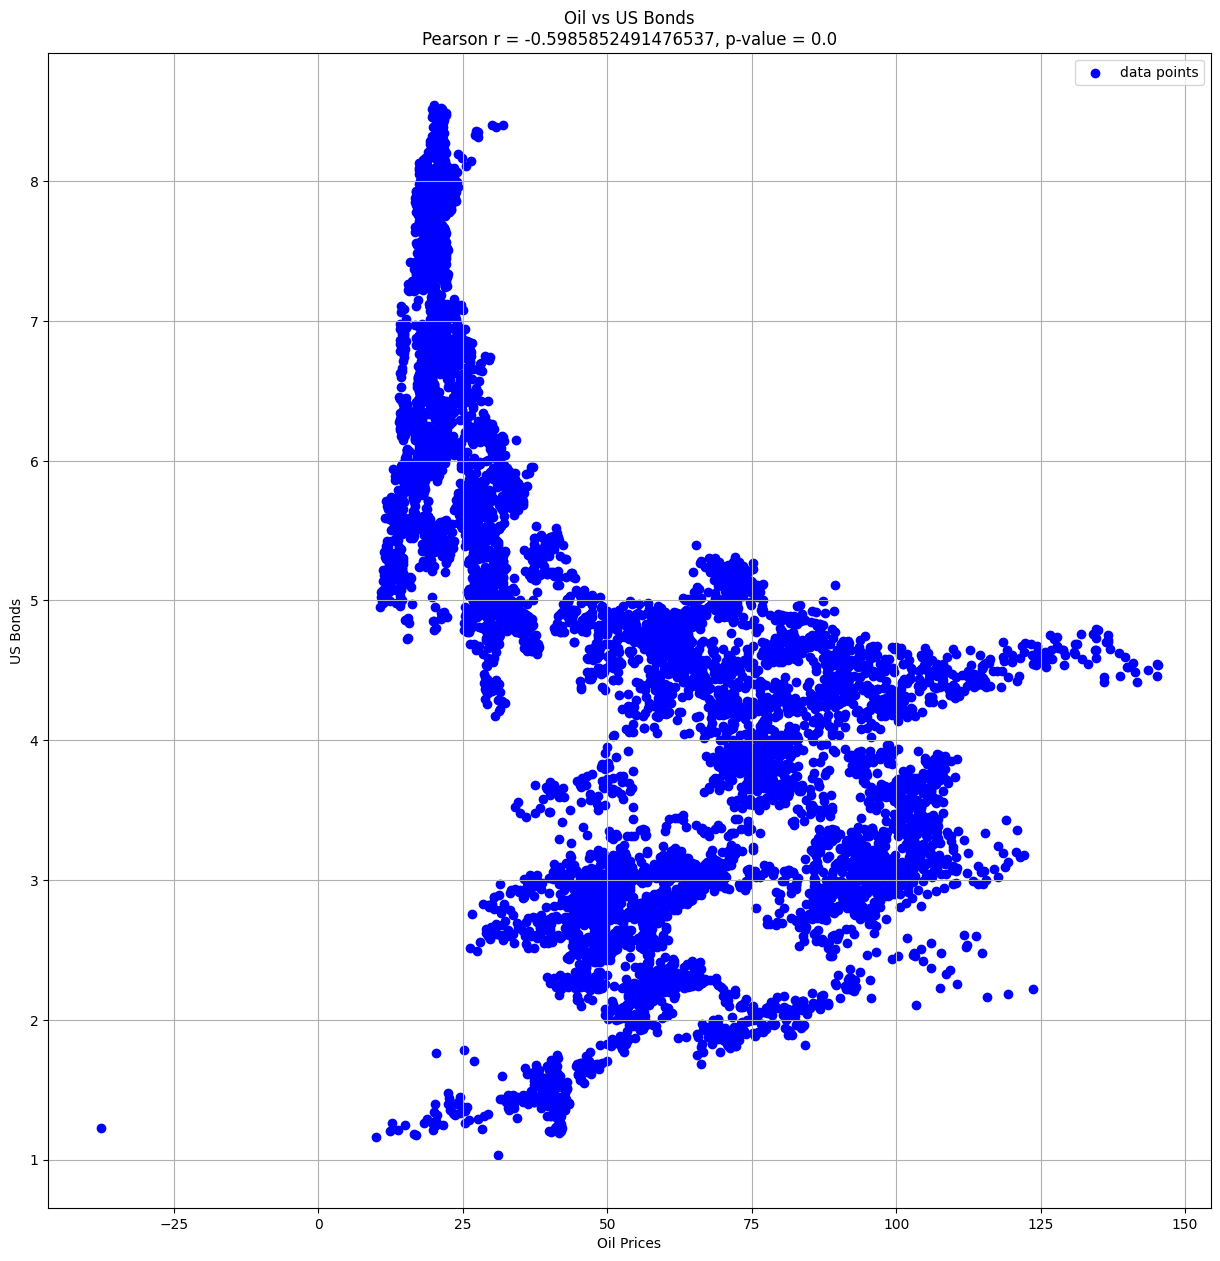

In [15]:
# Data cleaning and interpolation sections can be found below this code box

# 8 macroeconomic factors analyzed (US Bonds, US Dollar, US Economy, Gold, Euro, Japanese Yen, Natural Gas, Shale/Alternative Oil)
oil = pd.read_csv('interpolated_data/oil.csv') # Crude Oil (WTI)
bond = pd.read_csv('interpolated_data/bond_interpolated.csv') # US Bonds
dollar = pd.read_csv('interpolated_data/dollar_interpolated.csv') # US Dollar
euro = pd.read_csv('interpolated_data/euro_interpolated.csv') # Euro
exxon = pd.read_csv('interpolated_data/exxon_interpolated.csv') # Shale/Alternative Oil
gold = pd.read_csv('interpolated_data/gold_interpolated.csv') # Gold
yen = pd.read_csv('interpolated_data/japan_interpolated.csv') # Japanese Yen
ng = pd.read_csv('interpolated_data/ng_interpolated.csv') # Natural Gas
spy = pd.read_csv('interpolated_data/spy_interpolated.csv') # US Economy

# Concatenate DataFrames along the columns
merged_data = pd.concat([oil['Oil'],
                         bond['US Bonds'],
                         dollar['US Dollar'],
                         euro['Euro'],
                         exxon['Alternative Oil (Exxon)'],
                         gold['Gold'],
                         yen['Japanese Yen'],
                         ng['Natural Gas'],
                         spy['US Economy (Spy)']], axis=1)



# Pearson correlation test for oil and bonds
corr, p = pearsonr(oil['Oil'],  bond['US Bonds'])

print("Pearson correlation coefficient:", corr)
print(f"P-value: {p}")

plt.figure(figsize=(15, 15))
plt.scatter(oil['Oil'], bond['US Bonds'], color='blue', label='data points')

plt.xlabel('Oil Prices')
plt.ylabel('US Bonds')
plt.title(f"Oil vs US Bonds\nPearson r = {corr}, p-value = {p}")
plt.legend()
plt.grid(True)
plt.show()



# Oil vs US Bond Analysis
* Pearson correlation coefficient: -0.599
* P-value: 0.0
* Conclusion: There is a statistically significant, moderate negative linear correlation between WTI oil prices and US 10-Year Treasury Bond prices (or yields, depending on how 'Price' was defined in the raw data, as the plot suggests yields given the scale). As oil prices tend to go up, bond prices/yields tend to go down, and vice versa. This might reflect a flight-to-safety effect where rising oil prices (potentially indicating inflation or instability) drive investors towards bonds, lowering yields (or vice-versa).


Spearman correlation coefficient: -0.41738475670874364
P-value: 0.0


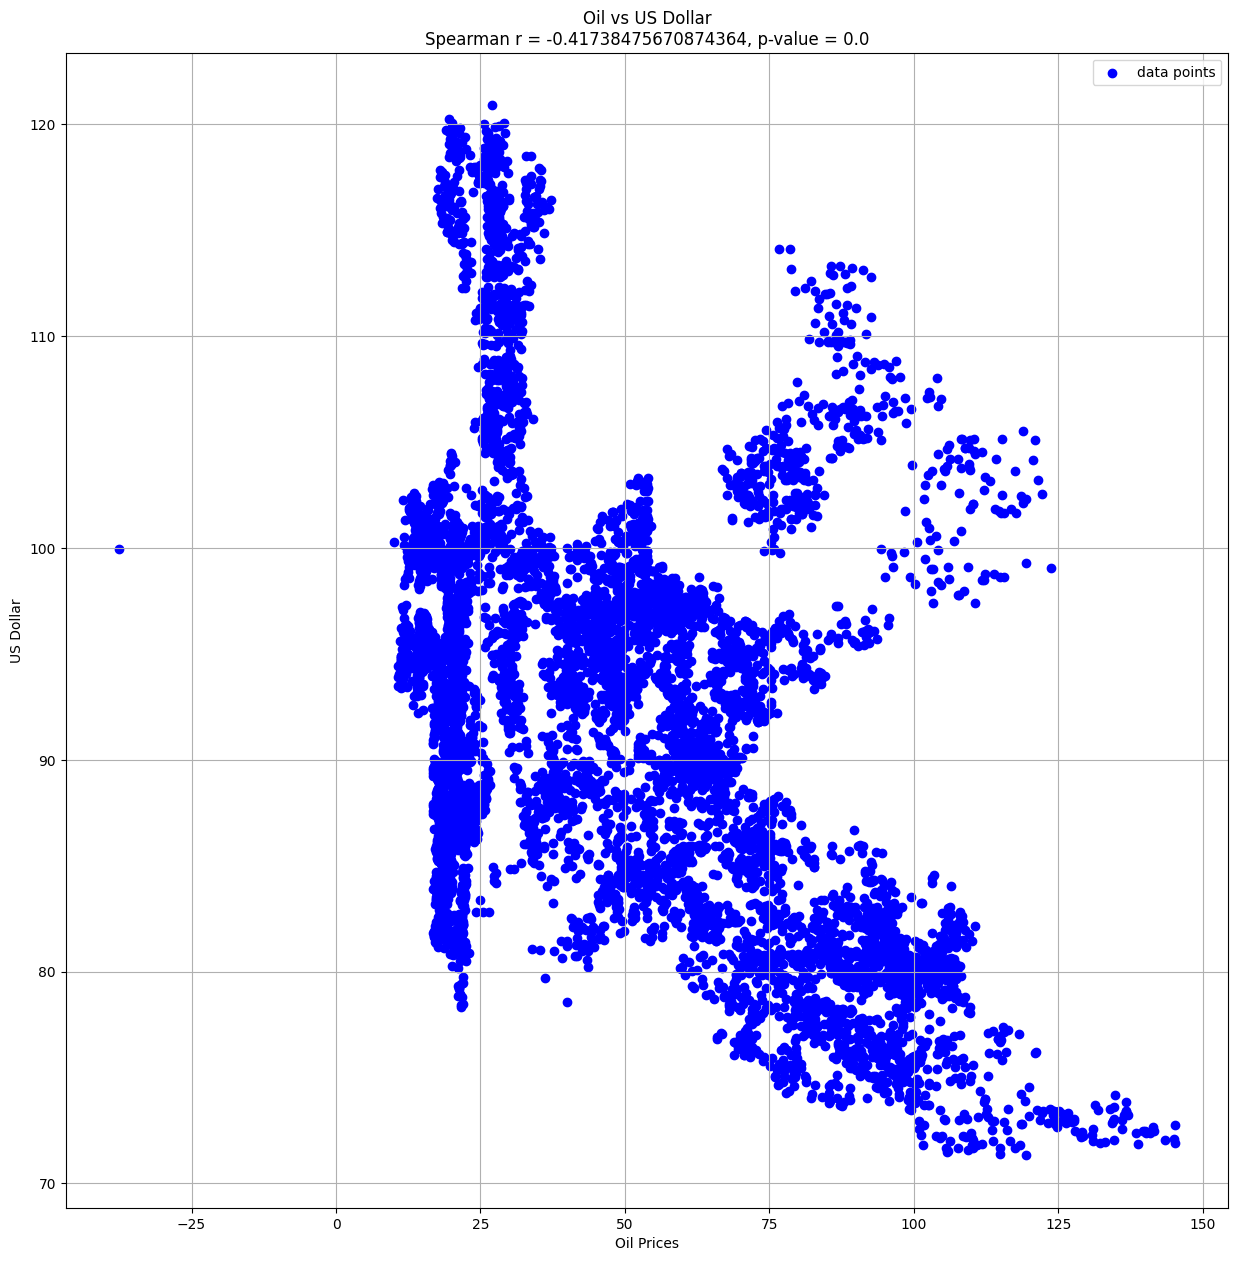

In [17]:

# Spearman's correlation test for oul and US dollar
corr, p = spearmanr(oil['Oil'], dollar['US Dollar'])

print("Spearman correlation coefficient:", corr)
print(f"P-value: {p}")

plt.figure(figsize=(15, 15))
plt.scatter(oil['Oil'], dollar['US Dollar'], color='blue', label='data points')

plt.xlabel('Oil Prices')
plt.ylabel('US Dollar')
plt.title(f"Oil vs US Dollar\nSpearman r = {corr}, p-value = {p}")
plt.legend()
plt.grid(True)
plt.show()


# Oil vs US Bond Analysis

* Spearman correlation coefficient: -0.417
* P-value: 0.0
* Conclusion: There is a statistically significant, moderate negative monotonic correlation between WTI oil prices and the US Dollar Index. Generally, a stronger dollar tends to correspond with lower oil prices (as oil is globally priced in USD), and a weaker dollar with higher oil prices.

Pearson correlation coefficient: 0.8371462583248163
P-value: 0.0


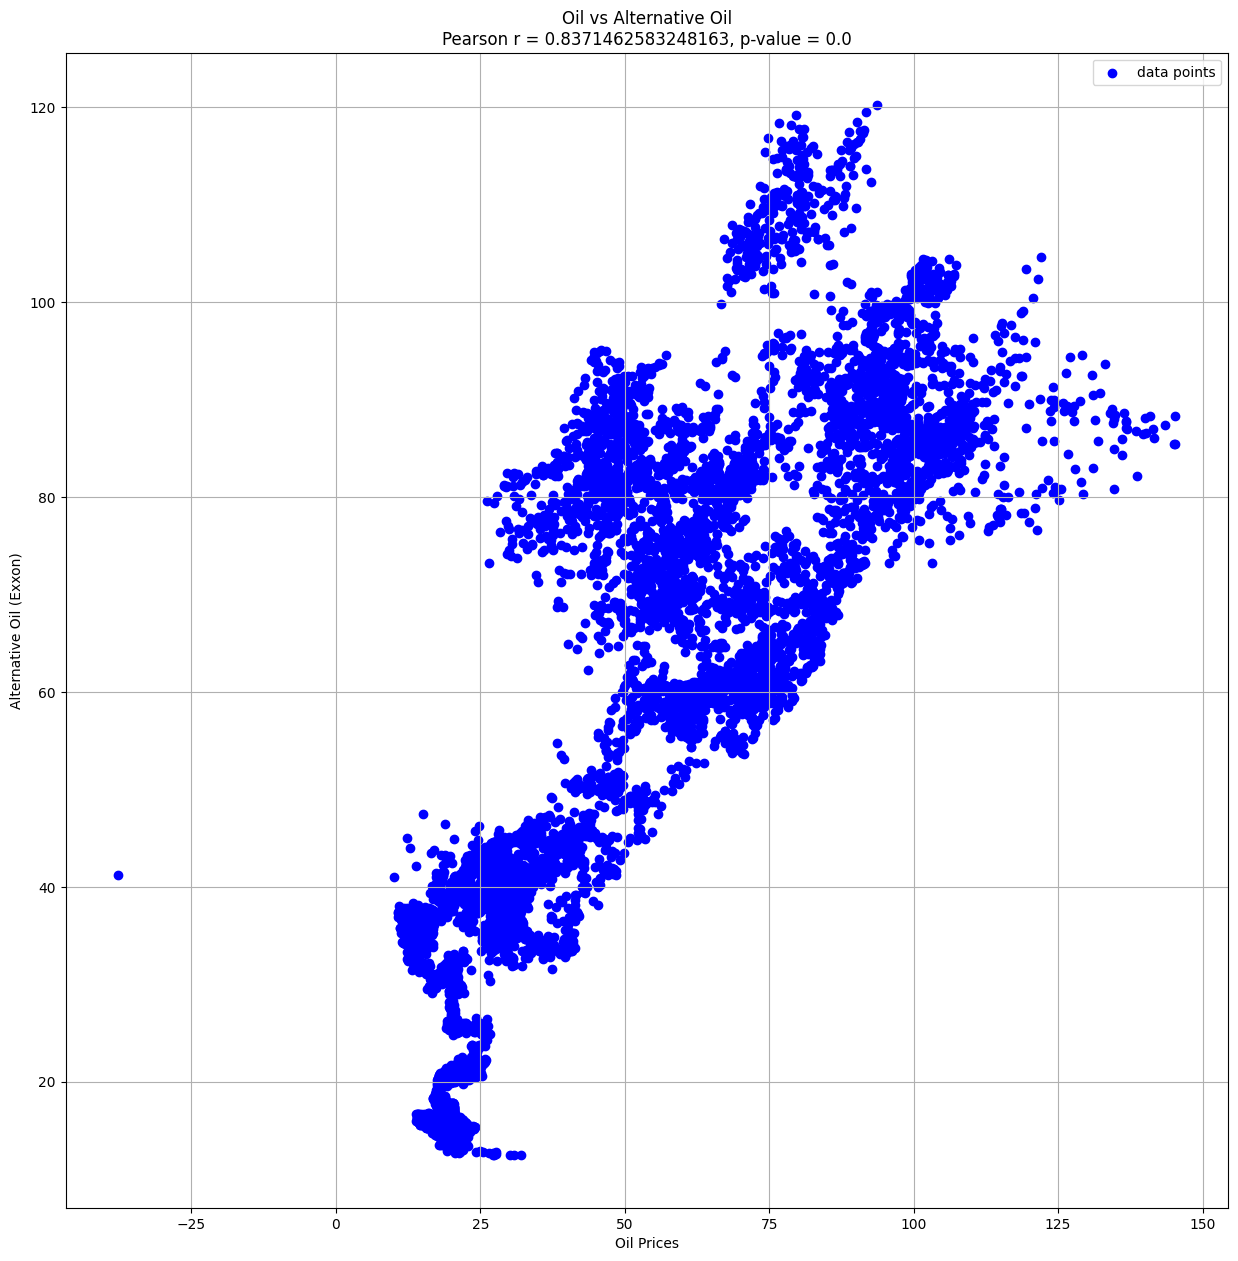

In [23]:

# Pearson correlation test for oil and alternative oil
corr, p = pearsonr(oil['Oil'],  exxon['Alternative Oil (Exxon)'])

print("Pearson correlation coefficient:", corr)
print(f"P-value: {p}")

plt.figure(figsize=(15, 15))
plt.scatter(oil['Oil'], exxon['Alternative Oil (Exxon)'], color='blue', label='data points')

plt.xlabel('Oil Prices')
plt.ylabel('Alternative Oil (Exxon)')
plt.title(f"Oil vs Alternative Oil\nPearson r = {corr}, p-value = {p}")
plt.legend()
plt.grid(True)
plt.show()



# Oil vs Alternative Oil Analysis (Exxon)
* Pearson correlation coefficient: 0.837
* P-value: 0.0
* Conclusion: There is a statistically significant, strong positive linear correlation between WTI oil prices and Exxon Mobil's stock price. This suggests that the performance of major oil producers, including those involved in alternative/shale oil, is closely tied to the price of crude oil.


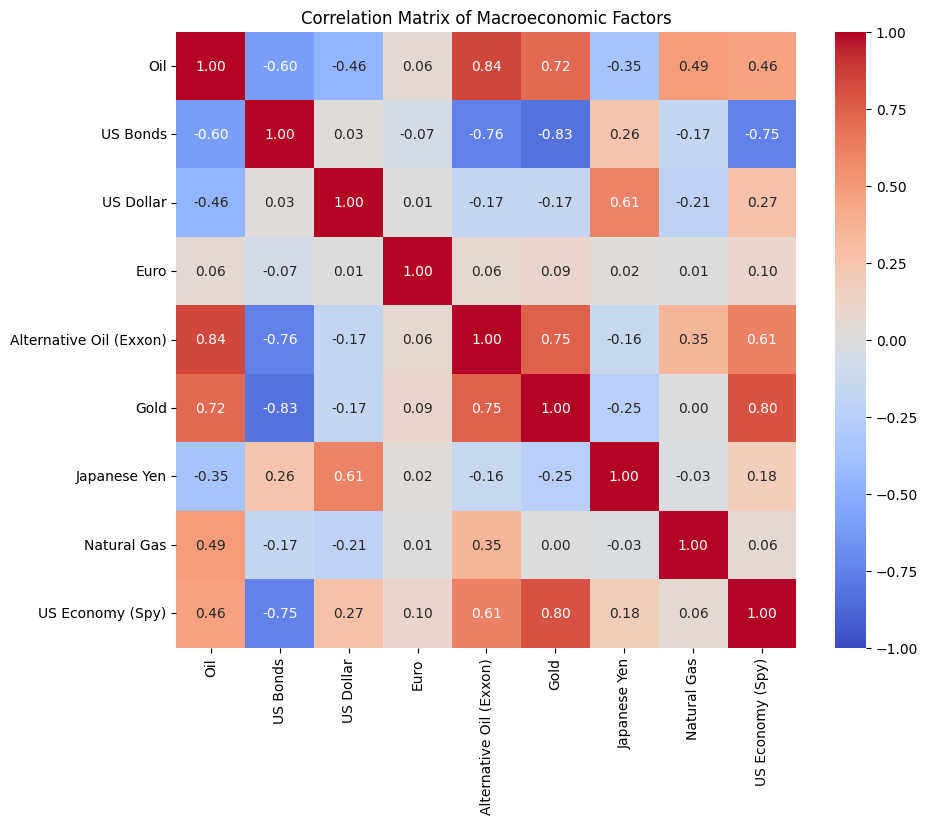

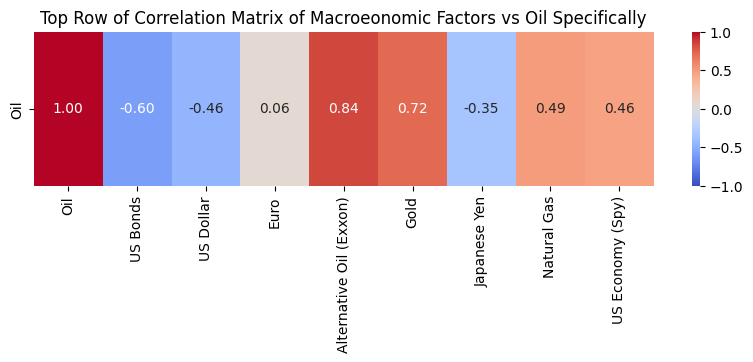

In [24]:

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()
# correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Macroeconomic Factors')
plt.show()

#  top row of the correlation matrix for ease of understanding
plt.figure(figsize=(10, 2))
sns.heatmap(correlation_matrix.iloc[:1, :], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Top Row of Correlation Matrix of Macroeonomic Factors vs Oil Specifically')
plt.show()



# Overall Correlation Matrix
* The heatmap visualization provides a comprehensive overview of all pairwise correlations.
* Key Observations (Top Row vs. Oil):
  * Strongest Positive: Exxon (+0.84), Gold (+0.72)
  * Moderate Positive: SPY (+0.58), Natural Gas (+0.48)
  * Weak/Near Zero: Euro (+0.06), Yen (-0.10)
  * Moderate Negative: US Dollar (-0.46)
  * Strongest Negative: US Bonds (-0.60)

### These exploratory findings confirm expected relationships (like Oil/Exxon, Oil/Dollar) and reveal others (like the strong negative Oil/Bond correlation and positive Oil/Gold correlation), providing a foundation for building a predictive model.

---

# **Primary Analysis**

Based on the exploratory analysis showing significant correlations between oil prices and several macroeconomic factors, we chose to build a regression model to predict WTI oil prices using these factors as features.


**Machine Learning Technique: Elastic Net Regression**

We selected Elastic Net regression for our primary analysis.
Elastic Net is a penalized linear regression model that combines the penalties of Lasso (L1) and Ridge (L2) regression.

*Reasoning:*

* **Handles Multicollinearity:** Financial and macroeconomic variables often exhibit multicollinearity (correlation among predictors). Elastic Net's Ridge component helps to mitigate the issues caused by this.

* **Feature Selection:** The Lasso component can shrink the coefficients of less important features towards zero, effectively performing feature selection, which can be useful even with a moderate number of features (8 in our case).

* **Balance:** It provides a balance between Lasso (which can sometimes arbitrarily select one feature from a group of correlated features) and Ridge (which tends to shrink coefficients of correlated features together).


**Implementation:**
1. Feature/Target Split: The merged_data DataFrame was split into features (X: the 8 macroeconomic factors) and the target variable (y: WTI Oil price).
2. Train-Test Split: The data was split into a training set (80%) and a testing set (20%) using train_test_split with random_state=42 for reproducibility. While a simple random split isn't ideal for time series, it provides a baseline evaluation. Time Series Cross-Validation was used later for a more robust assessment.
3. Feature Scaling: Features were standardized using StandardScaler. This is crucial for penalized regression models like Elastic Net, as it ensures all features contribute equally to the penalty term, preventing features with larger scales from dominating. The scaler was fit only on the training data and then used to transform both training and testing data to avoid data leakage.
4. Model Training: An ElasticNet model was instantiated (alpha=0.1, l1_ratio=0.7 - these hyperparameters control the overall penalty strength and the mix between L1/L2) and trained on the scaled training data (elastic_net.fit(X_train_scaled, y_train)).
5. Prediction: The trained model was used to predict oil prices on the scaled test set (y_pred = elastic_net.predict(X_test_scaled)).

**Evaluation:**
* Initial Train-Test Split:
  * Mean Squared Error (MSE): 87.71
  * R-squared (R²): 0.900
  * Interpretation: The R² value of 0.90 indicates that the model, using the 8 macroeconomic factors, can explain approximately 90% of the variance in WTI oil prices on the held-out test set. This suggests a strong predictive capability based on this initial split. The MSE gives a measure of the average squared difference between predicted and actual prices.


* Time Series Cross-Validation (TSCV):
  * To get a more reliable estimate of the model's performance over time, 5-fold time series cross-validation was performed using TimeSeriesSplit. This method ensures that the training set always precedes the test set in each fold, respecting the temporal nature of the data.
  * Results across 5 folds:
    * MSE: [34.36, 81.43, 132.04, 156.22, 98.90]
    * R-squared: [0.04, 0.69, 0.65, 0.72, 0.76] (Rounded for clarity)
  * Interpretation: The TSCV results show more variability. While some folds achieve good R² scores (up to 0.76), the first fold has a very low R² (0.04), indicating poor performance on that specific early time slice. The MSE also varies significantly. This suggests that while the model has potential, its performance might not be consistently high across all time periods, possibly due to changing market dynamics, overfitting on certain periods, or the influence of factors not included in the model. The average R² across the folds is lower than the initial 0.90, giving a more conservative estimate of the model's generalizability.

In [25]:

# Elstic Net Regression Model using the eight macroeconomic factors (The model combines both lasso and ridge regression)
# Select the features (X) and target variable (y)
X = merged_data.drop(['Oil'], axis=1)  # Assuming 'Date' is not a predictor
y = merged_data['Oil']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.7)  # Adjust alpha and l1_ratio as needed for penalties
elastic_net.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = elastic_net.predict(X_test_scaled)

# Sorting the predicted values since the data is time series based
sorted_indices = X_test.index.argsort()
X_test_sorted = X_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]


# **Visualization**
To visualize the performance of the **Elastic Net model**, we plotted the **predicted oil prices** against the **actual WTI oil prices** for the **test set period**.  
The **test set predictions** were **sorted chronologically** before plotting.

---

## **Plot Explanation:**
- The plot displays the **actual daily WTI oil prices** (**blue line**) over the entire dataset period and overlays the **predicted prices** from the **Elastic Net model** on the **test set portion** (**red line**).
- Visually, the **predicted prices (red)** generally track the **trends and movements** of the **actual prices (blue)** quite well during the test period, capturing major **upswings and downswings**.  
  - This aligns with the **high initial R-squared value**.

---

## **Observations:**
- However, there are **periods where the predictions deviate more significantly**, potentially reflecting the **variability** seen in the **time series cross-validation** results.
- The model appears to capture the **overall magnitude and direction** of price changes but may **lag slightly** or **miss the exact peaks and troughs**.
- Notably, the plot shows the **extreme event in April 2020** where **WTI prices went negative**.  
  - While the **test set** might not fully cover this period depending on the split, **linear models** like **Elastic Net** typically **struggle to predict such unprecedented black swan events accurately**, as they are trained on **historical patterns** that don't include such extremes.  
  - The predictions would likely not go **negative** or capture the **depth of that specific crash**.


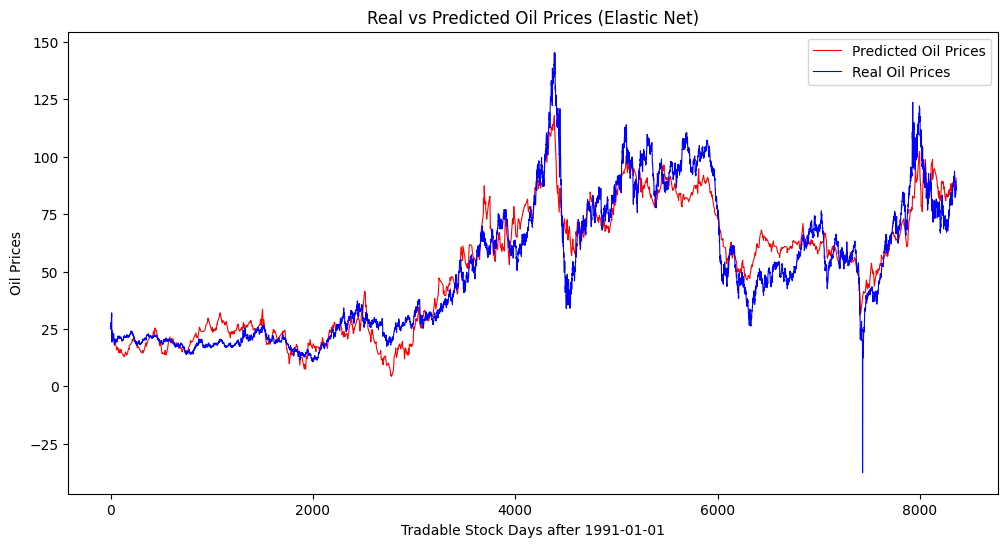

Mean Squared Error: 87.7050713955192
R-squared: 0.9002158537261145
Time Series Cross-Val Mean Squared Error: [34.36423578611308, 81.43223923275086, 132.0438491755038, 156.22180839839575, 98.90077627968164]
Time Series Cross-Val R-squared: [0.04362481848806987, 0.6915861442403775, 0.654891564646737, 0.7151475604322174, 0.7561008168302161]


In [26]:

# Plotting the predicted oil prices
plt.figure(figsize=(12, 6))
plt.plot(X_test_sorted.index, y_pred_sorted, label='Predicted Oil Prices', linestyle='-', linewidth=.8, color='red')

# Plotting the real oil prices (they were actually negative at some point in April 2020!)
plt.plot(merged_data['Oil'], label='Real Oil Prices', linestyle='-', linewidth=.8, color='blue')

plt.title('Real vs Predicted Oil Prices (Elastic Net)')
plt.xlabel('Tradable Stock Days after 1991-01-01')
plt.ylabel('Oil Prices')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Define the time series split across 5 intervals
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Initialize metrics for evaluation
all_mse = []
all_r2 = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize the features using the same scaler from the original model
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Make predictions on the test set
    y_pred = elastic_net.predict(X_test_scaled)

    # Evaluate the model and store metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    all_mse.append(mse)
    all_r2.append(r2)

print(f'Time Series Cross-Val Mean Squared Error: {all_mse}')
print(f'Time Series Cross-Val R-squared: {all_r2}')

# **Insights and Conclusions**
This analysis explored the relationship between **WTI crude oil prices** and eight key macroeconomic factors, culminating in the development of an **Elastic Net regression model** for price prediction.

---

## **Key Findings:**
- **Strong Correlations Exist:**  
  Exploratory data analysis confirmed significant correlations.  
  - WTI oil prices show a **strong positive linear correlation** with **Exxon Mobil stock** (proxy for alternative/shale oil, **r ≈ 0.84**) and **Gold** (**r ≈ 0.72**).  
  - A **strong negative linear correlation** was observed with **US Bonds** (**r ≈ -0.60**), and a **moderate negative monotonic correlation** with the **US Dollar Index** (**r ≈ -0.42**).  
  - Factors like the **Euro** showed **minimal linear correlation**.  

- **Predictive Model Performance:**  
  The **Elastic Net regression model** demonstrated **strong initial predictive power** on a standard train-test split, explaining about **90% of the variance** in oil prices (**R² ≈ 0.90**).

- **Time-Dependent Variability:**  
  Time series cross-validation revealed that the model's performance **varies across different time periods** (**R² ranging from 0.04 to 0.76**).  
  - This highlights the challenges of modeling financial time series, where relationships can shift, and suggests the model might be more reliable during certain **market regimes** than others.

---

## **Answering Introduction Questions:**
- The factors most strongly correlated with oil prices were **Exxon stock (positive)**, **Gold (positive)**, **US Bonds (negative)**, and the **US Dollar (negative)**.
- A predictive model using these factors achieved **high initial accuracy** (**R²=0.90**), but its robustness over time is **less consistent**, as shown by **TSCV**.  
  - It can provide **reasonable forecasts** but should be used with caution, especially during periods of **high volatility** or **structural market changes**.
- The correlations provide **economic insights**:  
  - The link between **crude and producer stocks (Exxon)**,  
  - The **inverse relationship** with the **US dollar** (commodity pricing),  
  - The potential role of **oil/bonds** in reflecting **risk sentiment** or **inflation expectations**,  
  - The connection to **gold** as an **inflation/uncertainty hedge**.  

---

## **Limitations:**
- **Interpolation:**  
  Filling missing data via interpolation, while necessary, might have **smoothed the data** or **introduced minor inaccuracies**.
- **Model Simplicity:**  
  **Elastic Net** is a **linear model** and may not capture **complex non-linear relationships** or **time-dependent dynamics** inherent in financial markets.
- **Feature Scope:**  
  The model only includes **eight factors**. Other crucial elements like **geopolitical events**, **OPEC decisions**, **inventory levels**, **weather patterns**, and **shifts in energy policy** were not explicitly included and can **significantly impact oil prices**.
- **Extreme Events:**  
  The model is **unlikely to predict extreme, unprecedented events** like the **negative prices seen in April 2020**.

---

## **Conclusions:**
The findings show that the identified **macroeconomic factors** do explain a **large portion of the movements** for the **WTI crude oil price**.  
- Many of the factors show especially interesting correlations:  
  - **Alternative energy production (Exxon)**,  
  - **Safe-haven assets (Gold, Bonds)**,  
  - **Currency strength (USD)**.  

**Elastic Net**, as a linear model, does a good job of retaining the **historical variance** in price. However, such models have **major fluctuations** in how reliable the predictions are over time. We interpreted this as being reflective of the many **complex factors** in the oil market.

The identified data factors in our analysis are a **good representation**, but there are other elements that will affect the data. Due to the essentially **infinite complexity** of the real world, there are always factors that the model does not explicitly have reference to.

---

## **Future Work:**
For future work in this project, we suggest:
- More **diverse data** may be helpful to create a more **comprehensive picture**.  
- **Time-series specific models** (like **ARIMA** or **LSTMs**) would also be a great way to **increase the abilities** of the predictive model.
